In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import math

### API words

In [2]:
def remove_punctuation(text):
    special_punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in text:
        if ele in special_punc:
            text = text.replace(ele, "")
    return text

In [3]:
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = ' '.join([word for word in text_tokens if not word in stopwords.words()])
    return tokens_without_sw

In [9]:
def stem(text):
    try:
        ps = PorterStemmer()
        return ps.stem(text)
    except:
        return text

In [5]:
def split_and_concat(df):
    dicte={}
    IDs=df['ID'].tolist()
    for ID in tqdm(IDs):
        df_del=df[df['ID']==ID]
        df_del=df_del.reset_index(drop=True)
        df_del['original_word']=df_del['ENGLISH'][0]
        df_del=df_del.reset_index(drop=True)
        list_words=df_del['ENGLISH'][0].split()
        for word in list_words:    
            df_del=df_del.append({'original_word':df_del['ENGLISH'][0],'ID':df_del['ID'][0],'FRENCH':df_del['FRENCH'][0],'ENGLISH':word,'THEME':df_del['THEME'][0],'IMPORTANT':df_del['IMPORTANT'][0]},ignore_index=True)
        df_del=df_del.drop(0)
        dicte[ID]=df_del

    df_new=pd.concat(dicte)
    df_new=df_new.reset_index(drop=True)
    return df_new

In [6]:
df=pd.read_csv('inputs/data.csv')
df_new=split_and_concat(df)
df_new['ENGLISH_stem']=df_new['ENGLISH'].apply(remove_punctuation).apply(stem)
df_new=df_new[df_new.ENGLISH_stem.notna()]

In [15]:
df_new

NameError: name 'df_new' is not defined

### On importe les mots de Wiki pour obtenir les Occurences 2

In [11]:
df4=pd.read_csv('inputs/WikiWords_FirstMillion_Refined_V6.csv')
df4.columns=['ENGLISH','OCCURENCES']
df4=df4[df4['ENGLISH'].notna()]
df4=df4.drop_duplicates(subset=['ENGLISH'])

In [12]:
df4

,ENGLISH,OCCURENCES
0,amp,15034
1,is,1057392
2,a,1936240
3,double,3366
4,ampersand,17
...,...,...
75487,sair,1
75488,impulsion,1
75489,abogados,3
75490,trypanosomiasis,1


In [13]:
df4_new=df4.copy()
df4_new['ENGLISH_stem']=df4_new['ENGLISH'].apply(stem)
df4_new=df4_new.drop_duplicates(subset=['ENGLISH_stem'])

In [14]:
df4_new

,ENGLISH,OCCURENCES,ENGLISH_stem
0,amp,15034,amp
1,is,1057392,is
2,a,1936240,a
3,double,3366,doubl
4,ampersand,17,ampersand
...,...,...,...
75485,dispender,1,dispend
75487,sair,1,sair
75489,abogados,3,abogado
75490,trypanosomiasis,1,trypanosomiasi


#### Merge des deux tables (wiki+data.csv)

In [16]:
df5_new=df_new.merge(df4_new,how='outer',left_on=['ENGLISH_stem'],right_on=['ENGLISH_stem'])

IDS_doubt=df5_new[(df5_new['FRENCH'].notna())&(df5_new['OCCURENCES'].isna())].ID.unique().tolist()

str(round(len(IDS_doubt)/len(df)*100,2))+'%'

#### Get final table (deduplication en prenant l'occurence du mot le moins fréquent)

In [125]:
df_final=df5_new[(df5_new['FRENCH'].notna())&(df5_new['OCCURENCES'].notna())&(~df5_new.ID.isin(IDS_doubt))]
df_final=df_final[['ID','FRENCH','original_word','THEME','ENGLISH_x','ENGLISH_stem','OCCURENCES']].sort_values(by=['ID'])

In [126]:
IDs=df_final['ID'].unique().tolist()
dicte={}
for id_ in tqdm(IDs):    
    df_del=df_final[df_final.ID==id_]
    df_del=df_del.reset_index(drop=True)
    occurences=df_del.OCCURENCES.unique().tolist()
    index_min=occurences.index(min(occurences))
    df_del2=pd.DataFrame(columns=df_del.columns)
    df_del2=df_del2.append({'original_word':df_del['original_word'][0],'ID':id_,'FRENCH':df_del['FRENCH'][0],'ENGLISH':df_del['ENGLISH_x'][index_min],'THEME':df_del['THEME'][0],'ENGLISH_stem':df_del['ENGLISH_stem'][index_min],'OCCURENCES':df_del['OCCURENCES'][index_min]},ignore_index=True)
    dicte[id_]=df_del2
df_final=pd.concat(dicte)
df_final=df_final.reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████| 7746/7746 [01:02<00:00, 124.18it/s]


#### On applique des derniers filtre avant d'exporter

In [127]:
df_final['_len']=df_final['original_word'].apply(len)
df_final=df_final[df_final._len<18]
df_final=df_final[~(df_final['FRENCH']==df_final['original_word'])]

### On importe les mots traduits avec Google Sheet/Translate et transformés dans "Google_translate.ipynb"

In [16]:
df_bonus=pd.read_csv('output/additional_data.csv')

In [148]:
df_bonus=pd.read_csv('output/additional_data.csv')
df_bonus=df_bonus.drop(columns=['_len','_fuzzy_ration'])
df_bonus['THEME']="other"
max_id=int(df_final['ID'].max())
ID_bonus=list(range(max_id+1,max_id+1+len(df_bonus)))
df_bonus['ID']=ID_bonus

In [149]:
df_final2=df_final.drop(columns=['_len','ENGLISH_x','ENGLISH'])
df_final2.columns=['ID','FRENCH','ENGLISH','THEME','ENGLISH_stem','OCCURENCES']

#### On merge df_final2 et df_bonus, et on mélange le tout

In [150]:
df_final3=pd.concat((df_final2,df_bonus))

df_final3=df_final3.sample(frac=1)

### Interval creation

In [152]:
df_final4=df_final3.copy()
df_final4['INTERVAL']=pd.qcut(df_final4['OCCURENCES'],100,duplicates='drop',labels=False)
df_final4['INTERVAL']=100-df_final4['INTERVAL']
df_final4['IMPORTANT']=np.nan

In [153]:
#Debug
def remove_punctuation2(text):
    special_punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in text:
        if ele in special_punc:
            text = text.replace(ele, " ")
    return text
df_final4['FRENCH']=df_final4['FRENCH'].apply(remove_punctuation2)
df_final4['ENGLISH']=df_final4['ENGLISH'].apply(remove_punctuation2)
df_final4['THEME']=df_final4['THEME'].apply(remove_punctuation2)

In [154]:
df_final4.to_csv('output/data.csv',index=False)

<AxesSubplot:>

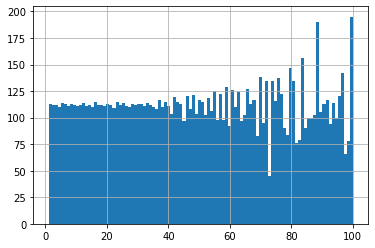

In [145]:
df_final4['INTERVAL'].hist(bins=100)

In [233]:
  //list_of_list[0] -> IDs
  //list_of_list[1] -> ENG
  //list_of_list[2] -> FR
  //list_of_list[3] -> THEME
  //list_of_list[4] -> OCCURENCE